# context

Notebook is code for analyzing data for the 2022 Spring Semester course Computational Genomics (CBMF W4761) at Columbia University.

- [Dylan Marshall](dmm2269@cumc.columbia.edu), Columbia Systems Biology PhD student
- [Julia Urban](jau2112@cumc.columbia.edu), Columbia Systems Biology PhD student
- [Peiwen Cai](pc2976@cumc.columbia.edu), Columbia Systems Biology PhD student

# set up

In [1]:
%%capture
!pip install biopandas

In [2]:
from functools import reduce
from itertools import product, repeat
import os, gc, pickle, sys

In [3]:
from biopandas.pdb import PandasPdb
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist,squareform
import pandas as pd
from sklearn.metrics import pairwise_distances

from matplotlib_venn import venn3
from itertools import product as product
plt.rcParams['figure.figsize'] = [8, 8]

# methods

In [4]:
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a, n in zip(alphabet, range(states)):
  a2n[a] = n

In [5]:
def aa2num(aa):
  """convert aa into num"""
  if aa in a2n: return a2n[aa]
  else: return a2n["-"]

In [6]:
def get_eff(X, thresh=0.8):
  """compute effective weight for each sequence"""
  L = X.shape[1]
  # pairwise identity
  X_pid = 1.0-squareform(pdist(X, "hamming"))
  # weight for each sequence
  W = (X_pid >= thresh).astype(float)
  W = 1/np.sum(W, -1)
  return W

In [7]:
def mk_msa(seqs):
  """converts list of sequences to msa and msa weights"""
  X = []
  for seq in seqs:
    X.append([aa2num(aa) for aa in seq])
  X = np.array(X)
  # per-sequence effective weight
  W = get_eff(X, 0.8)
  return np.eye(21)[X], W

# load

In [8]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [9]:
def load_data(pdb, _dir, chains):
  """ """

  def _coords2dm(coords): return squareform(pdist(coords))

  # AlphaFold2
  _af2 = "rank_1_model_1_ptm_seed_0_relaxed.pdb"
  af2 = PandasPdb().read_pdb(_dir+"{}/".format(pdb)+_af2).df["ATOM"]
  af2 = af2[af2["atom_name"] == "CA"]
  lA, lB = sum(af2["chain_id"] == "A"), sum(af2["chain_id"] == "B")
  adm = _coords2dm(af2[["x_coord", "y_coord", "z_coord"]])[:lA, lA:]
  # Sequences 
  msa = np.load(_dir+"{}/msa.pickle".format(pdb), allow_pickle=True)["msas"][0]
  sA, sB = msa[0][:lA], msa[0][lA:]
  # Coevolution
  mrf = np.load(_dir+"{}/{}_coevo.pickle".format(pdb, pdb), allow_pickle=True)
  subs = range(17)
  mrfs = {s: stats.zscore(mrf[s]["coevo"][:lA, lA:], None).reshape(lA, lB)
    for s in subs}
  # Experimental
  cA, cB = chains
  exp = PandasPdb().fetch_pdb(pdb).df["ATOM"]
  exp = exp[exp["atom_name"] == "CA"]
  exp = exp[(exp["chain_id"] == cA) | (exp["chain_id"] == cB)]
    # index matching
  exp_coords = np.array(list(repeat(np.nan, (lA+lB)*3))).reshape((lA+lB, 3))
  ij2ij = exp.apply(lambda x:
    x["residue_number"]-1 if x["chain_id"] == cA else x["residue_number"]-1+lA,
    axis=1
  )
  exp_coords[ij2ij, :] = exp[["x_coord", "y_coord", "z_coord"]]
  edm = _coords2dm(exp_coords)[:lA, lA:]
  return {"seq": sA+":"+sB, "af2": adm, "mrf": mrfs, "exp": edm}

In [10]:
_dir = "drive/MyDrive/__courses/compGen/project/final_pipeline/"
pdbs = ["2Y69", "3RRL", "1EP3", "1RM6"]
data = {pdb: load_data(pdb, _dir, ab) for pdb, ab in zip(
    pdbs,
    [["A", "C"], ["A", "B"], ["A", "B"], ["B", "C"]]
  )}

# pairwise maps

In [ ]:
def pwm(pdb, cat=None, sub=None):
  """ """
  
  if sub in range(17): pw = data[pdb][cat][sub]
  else: pw = data[pdb][cat]
  lA, lB = pw.shape[0], pw.shape[1]
  F, A = plt.subplots(1, 1, figsize=(10*lB/(lA+lB), 8.5*lA/(lA+lB)))
  sns.heatmap(pw, cmap="Blues", ax=A)
  plt.show();

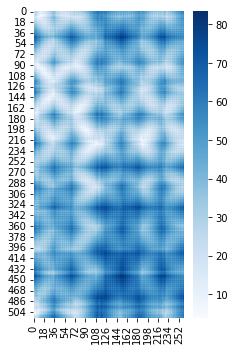

In [ ]:
#@markdown 2Y69 experiment
pwm("2Y69", "exp")

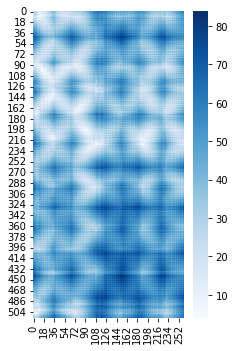

In [ ]:
#@markdown 2Y69 alphafold2
pwm("2Y69", "af2")

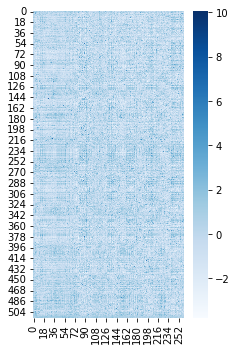

In [ ]:
#@markdown 2Y69 MRF full MSA
pwm("2Y69", "mrf", 0)

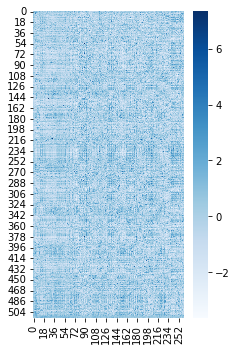

In [ ]:
#@markdown 2Y69 MRF subsample-1 MSA
pwm("2Y69", "mrf", 1)

# coevo signal stats

In [13]:
def ij_coevo_sig(pdb, thresh):
  """ """
  # subsamples, 0 == full MSA
  subs = range(17)
  _dim = data[pdb]["exp"].shape
  mz = {s: data[pdb]["mrf"][s] for s in subs}
  # indices wrt angstrom threshold
  ei = data[pdb]["exp"] < thresh
  ai = data[pdb]["af2"] < thresh
  mi = {}
  for s in subs:
    mi[s] = mz[s] > np.sort(mz[s], None)[-ei.sum()]
  # signals: background, only MRF, all three
  bg, om, at = {}, {}, {}
  for s in subs:
    bg[s] = mz[s][mi[s] == False]
    om[s] = mz[s][mi[s]*(ei == False)*(ai == False)]
    if (mi[s]*ei*ai).sum() == 0: at[s] = np.array([])
    else: at[s] = mz[s][mi[s]*ei*ai]
  return {"ei": ei, "ai": ai, "mi": mi, "mz": mz, "bg": bg, "om": om, "at": at}

In [14]:
# indices and coevolution signal
ijcs = {pdb: {thresh: ij_coevo_sig(pdb, thresh)
    for thresh in [5, 10]} for pdb in pdbs
}

## visualization 1: differential coevo signal distributions in boxplots

In [ ]:
def box_sub(sub):
  """ """
  F, A = plt.subplots(4, 1, sharex=True, figsize=(8, 14))
  for i, pdb in enumerate(pdbs):
    # background, only MRF, all three
    _bg = ijcs[pdb][10]["bg"][sub]
    _om = ijcs[pdb][10]["om"][sub]
    _at = ijcs[pdb][10]["at"][sub]
    # statistical significance via Mann-Whitney U rank test
    bg_at = np.format_float_scientific(stats.mannwhitneyu(_bg, _at)[1], 3)
    om_at = np.format_float_scientific(stats.mannwhitneyu(_om, _at)[1], 3)
    # plot
    A[i].boxplot([_bg, _om, _at], vert=False, showfliers=False)
    A[i].set_yticklabels([x+"\nN="+str(len(y)) for x, y in zip(["_bg", "_om", "_at"], [_bg, _om, _at])])
    A[i].set_title(f"{pdb} ({sub}), MWU: bg-at {bg_at}, om-at {om_at}")
  A[-1].set_xlabel("coevolution signal, z-score normalized")
  _f = "_".join(["bp", str(sub)+".pdf"])
  plt.savefig(_f, type="pdf", transparent=True, bbox_inches="tight")
  plt.show();

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

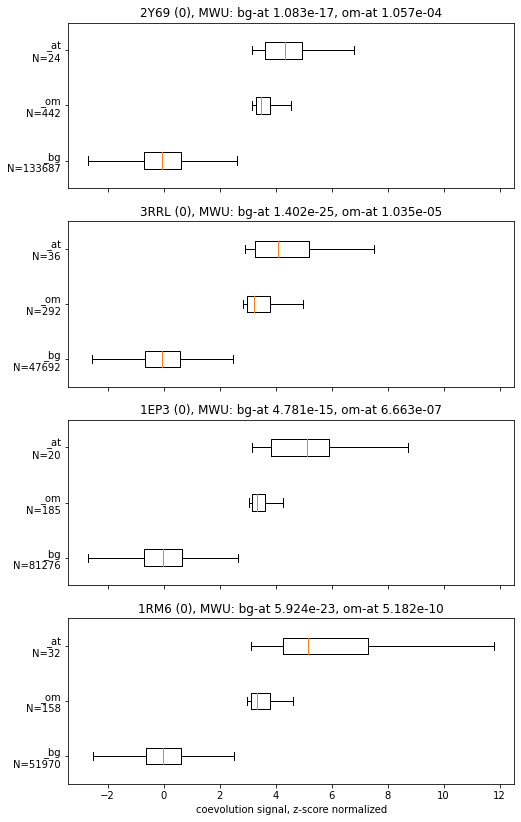

In [ ]:
#@markdown full MSA
box_sub(0)

In [ ]:
# all
%%capture
for s in range(17): box_sub(s)

In [ ]:
!zip boxplots.zip *.pdf

  adding: bp_0.pdf (deflated 31%)
  adding: bp_10.pdf (deflated 31%)
  adding: bp_11.pdf (deflated 31%)
  adding: bp_12.pdf (deflated 31%)
  adding: bp_13.pdf (deflated 31%)
  adding: bp_14.pdf (deflated 31%)
  adding: bp_15.pdf (deflated 31%)
  adding: bp_16.pdf (deflated 31%)
  adding: bp_1.pdf (deflated 31%)
  adding: bp_2.pdf (deflated 31%)
  adding: bp_3.pdf (deflated 30%)
  adding: bp_4.pdf (deflated 31%)
  adding: bp_5.pdf (deflated 31%)
  adding: bp_6.pdf (deflated 31%)
  adding: bp_7.pdf (deflated 31%)
  adding: bp_8.pdf (deflated 31%)
  adding: bp_9.pdf (deflated 31%)


# visualization 2: venn diagram, jaccard similarity

In [41]:
def venn(ijcs, cutoff, pdb, tol = None, label = True, output_name = 'venn.png'):
  plt.rcParams.update({'font.size': 20})
  ijcs_sub = ijcs[pdb][cutoff]

  set1 = set(_np_to_tup(np.argwhere(ijcs_sub.get('ei')==True)))
  set2 = set(_np_to_tup(np.argwhere(ijcs_sub.get('ai')==True)))
  set3 = set(_np_to_tup(np.argwhere(ijcs_sub.get('mi')[0]==True)))
  
  if tol is None:
    plt.title('{}, < {}'.format(pdb.upper(), cutoff))
  else:    
    plt.title('{}, < {}Å, if allowing co-evolving sites from >={}% MRFs'.format(pdb.upper(), cutoff, tol*100))
  labs = ('Groundtruth', 'AF2', 'MRF') if label else ('','','')
  v=venn3([set1, set2, set3], labs, set_colors=('#88d3f6','#f192c5', '#fef988'), alpha = 0.8)
  overlaps = {'111':'#dbbc69','101':'#c6e380','110':'#b47cc1'}
  for k,col in overlaps.items():
    try:
      v.get_patch_by_id(k).set_color(col)
    except AttributeError:
      continue

  plt.show()
  plt.savefig(output_name)
  plt.close()

def _np_to_tup(arr):
  return set(map(tuple, arr))

def jaccard(ijcs, cutoff, pdb, subset, font_size=16, vmin=None, vmax=None, annotate = False, output_name = 'jaccard.png'):
  '''
  calculates pairwise Jaccard similarity scores between experimental / AF2 / MRF coordinates for a given protein at a given cutoff (5 or 10 A) 
  visualizes in seaborn heatmap
  '''
  plt.rcParams.update({'font.size': font_size})
  ijcs_sub = ijcs[pdb][cutoff]
  mrf_coords = dict()
  set1 = set(_np_to_tup(np.argwhere(ijcs_sub.get('ei')==True)))
  set2 = set(_np_to_tup(np.argwhere(ijcs_sub.get('ai')==True)))
  for mrf_trial in range(17):
    set3 = set(_np_to_tup(np.argwhere(ijcs_sub.get('mi')[mrf_trial]==True)))
    if subset == 'at': # triple intersection
      mrf_coords['Sub_{}'.format(mrf_trial) if mrf_trial > 0 else 'Full'] = set1.intersection(set2).intersection(set3)
    if subset == 'bg':
      mrf_coords['Sub_{}'.format(mrf_trial) if mrf_trial > 0 else 'Full'] = set([x for x in set3 if x not in set1 or x not in set2])
  names = {x:i for i, x in enumerate(mrf_coords.keys())}
  mtx = np.zeros((len(names),len(names)))

  for n1, n2 in product(mrf_coords.keys(),mrf_coords.keys()):
    set1, set2 = mrf_coords.get(n1), mrf_coords.get(n2)
    intersect = len(set1.intersection(set2))
    union = (len(set1) + len(set2)) - intersect
    mtx[names.get(n1),names.get(n2)] = float(intersect) / union

  df = pd.DataFrame(mtx,columns=mrf_coords.keys(),index=mrf_coords.keys())
  if vmin is not None and vmax is not None:
    sns.clustermap(df, annot=annotate, cmap="YlGnBu", vmin = vmin, vmax = vmax)
  else:
    sns.clustermap(df, annot=annotate, cmap="YlGnBu")
  plt.savefig(output_name)
  plt.close()


def jaccard_pb(ijcs, cutoff, pdb, font_size = 16, vmin=None, vmax=None, annotate = True, output_name = 'jaccard.png'):
  '''
  similar to jaccard() above, but calculates the average jaccard scores of all the MRF trials run on subsampled MSAs with AF2 / experimental / (OG) MRF coordinates
  '''
  plt.rcParams.update({'font.size': font_size})
  plt.rcParams['figure.figsize'] = [6, 6]

  ijcs_sub = ijcs[pdb][cutoff]
  mrf_coords = dict()
  mrf_coords['exp'] = set(_np_to_tup(np.argwhere(ijcs_sub.get('ei')==True)))
  mrf_coords['af2'] = set(_np_to_tup(np.argwhere(ijcs_sub.get('ai')==True)))
  mrf_coords['mrf'] = set(_np_to_tup(np.argwhere(ijcs_sub.get('mi')[0]==True)))

  for mrf_trial in range(17):
    if mrf_trial != 0:
      mrf_coords['sub_{}'.format(mrf_trial)] = set(_np_to_tup(np.argwhere(ijcs_sub.get('mi')[mrf_trial]==True)))
    
  keys = list(mrf_coords.keys())
  mk_keys = [x for x in keys if x.startswith('sub_')]
  essential_keys = ['af2','exp','mrf']

  names = {x:i for i, x in enumerate(keys)}
  mtx = np.eye(len(names),len(names)) if len(mk_keys)==0 else np.eye(len(names)+1,len(names)+1)
  for n1, n2 in product(names,names):
    set1, set2 = mrf_coords.get(n1), mrf_coords.get(n2)
    set1 = _np_to_tup(set1)
    if n1 == 'exp': set1 = {(x[0]-1,x[1]-1) for x in set1}
    set2 = _np_to_tup(set2)
    if n2 == 'exp': set2 = {(x[0]-1,x[1]-1) for x in set2}
    intersect = len(set1.intersection(set2))
    union = (len(set1) + len(set2)) - intersect
    mtx[names.get(n1),names.get(n2)] = float(intersect) / union

  if len(mk_keys) >1:
    names.update({'mrf_sub_avg':len(keys)})
    for ek in essential_keys:
      val = np.mean([mtx[names.get(ek), names.get(mk)] for mk in mk_keys])
      mtx[names.get(ek),names.get('mrf_sub_avg')] = val
      mtx[names.get('mrf_sub_avg'),names.get(ek)] = val
    keys_trim = ['af2','exp','mrf','mrf_sub_avg']

    names_trim = {x:i for i, x in enumerate(keys_trim)}
    mtx_trim = np.eye(len(keys_trim), len(keys_trim))
    for k1, k2 in product(keys_trim, keys_trim):
      if k1 not in mk_keys and k2 not in mk_keys:
        mtx_trim[names_trim.get(k1),names_trim.get(k2)]=mtx[names.get(k1),names.get(k2)]
    df = pd.DataFrame(mtx_trim,columns=names_trim,index=names_trim)
  else:    
    df = pd.DataFrame(mtx,columns=mrf_coords.keys(),index=mrf_coords.keys())
  if vmin is not None and vmax is not None:
    sns.clustermap(df, annot=annotate, cmap="YlGnBu", vmin = vmin, vmax = vmax)
  else:
    sns.clustermap(df, annot=annotate, cmap="YlGnBu")
  plt.savefig(output_name)
  plt.close()

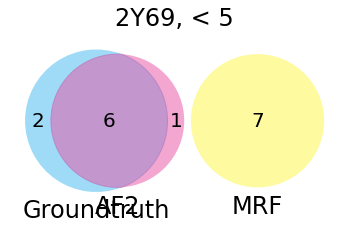

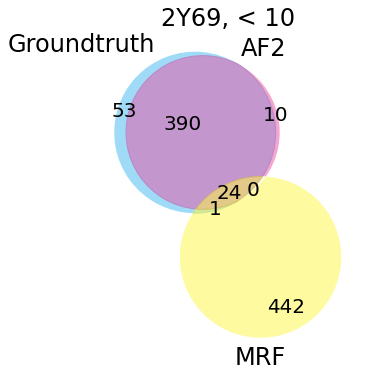

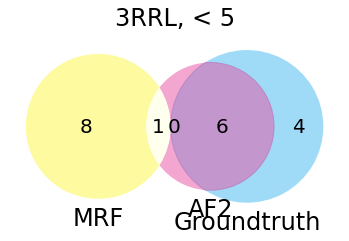

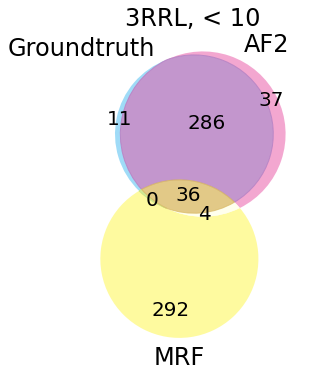

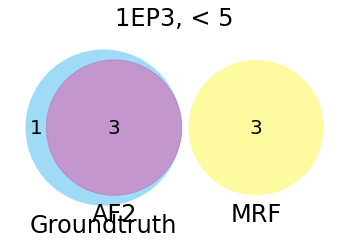

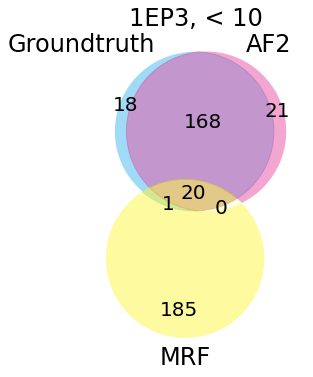

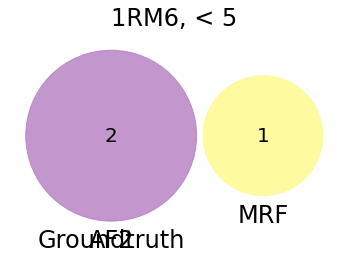

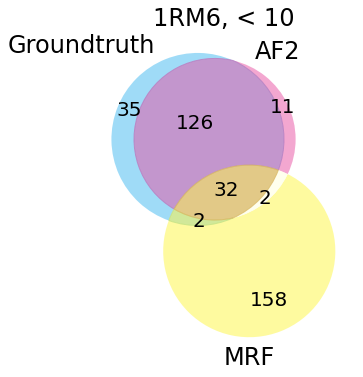

In [42]:
pdbs = ["2Y69", "3RRL", "1EP3", "1RM6"]

for pdb in pdbs:
  venn(ijcs, cutoff=5, pdb=pdb)
  venn(ijcs, cutoff=10, pdb=pdb)

  cutoff =10
  subset = 'at'
  jaccard(ijcs, cutoff=10, pdb=pdb, subset = subset,
          vmin = 0.0, vmax=1.0,
          output_name = 'jaccard_{}_{}_{}.pdf'.format(pdb, cutoff,subset))

  subset = 'bg'
  jaccard(ijcs, cutoff=cutoff, pdb=pdb, subset = subset,
          vmin = 0.0, vmax=1.0,
          output_name = 'jaccard_{}_{}_{}.pdf'.format(pdb, cutoff,subset))

  jaccard_pb(ijcs, cutoff=cutoff, pdb=pdb, 
          vmin = 0.0, vmax=1.0,
          output_name = 'jaccard_{}_{}_{}.pdf'.format(pdb, cutoff,'pb'))
